In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.animation as animation
plt.rcParams["animation.ffmpeg_path"] = "C:\\Users\\Nathan\Desktop\\ffmpeg-5.1.2-essentials_build\\bin\\ffmpeg.exe"

In [152]:
# neatly format csv as a data frame

df = pd.read_csv("M9_ON3___2000croppedDLC_resnet50_M9Jul27shuffle1_10000.csv").iloc[2:]
body_parts = ["head", "body", "tail"]
suffixes = ["_x", "_y", "_likelihood"]
df.columns = ["coords"] + [part+suffix for part in body_parts for suffix in suffixes]
df.set_index("coords", inplace=True)
df.drop([part + suffixes[2] for part in body_parts], axis=1, inplace=True)

df

,head_x,head_y,body_x,body_y,tail_x,tail_y
coords,,,,,,
0,87.61434936523438,137.75936889648438,120.88501739501953,181.34059143066406,128.6064910888672,218.2353973388672
1,87.30823516845703,139.19960021972656,122.6283950805664,181.21580505371094,131.36489868164062,219.1704559326172
2,82.1679458618164,138.3261260986328,122.16996002197266,181.26812744140625,133.3811798095703,218.855224609375
3,80.95723724365234,138.1174774169922,121.67192077636719,181.6720733642578,134.4748992919922,218.9170684814453
4,79.80023956298828,137.70254516601562,120.91250610351562,181.24050903320312,134.79342651367188,218.34255981445312
...,...,...,...,...,...,...
10374,215.4625701904297,302.59661865234375,233.33624267578125,228.04222106933594,246.31539916992188,177.00396728515625
10375,217.73251342773438,311.1137390136719,234.16201782226562,237.93585205078125,245.14059448242188,184.57818603515625
10376,215.38255310058594,318.72821044921875,232.41407775878906,243.24806213378906,237.84042358398438,187.83834838867188


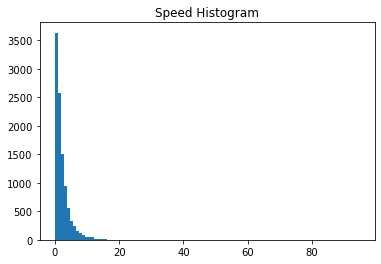

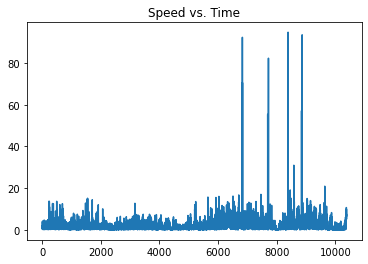

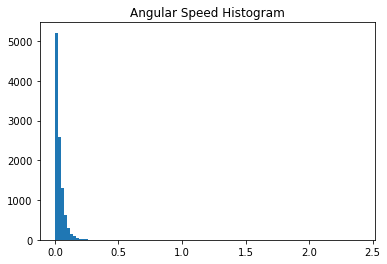

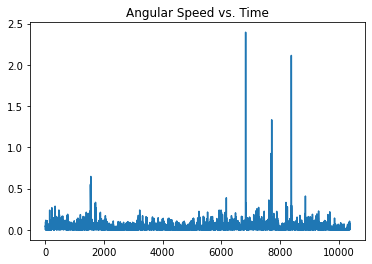

In [153]:
# constants
LPP = 1 # length per pixel 
TPF = 1 # time per frame

# --- helper functions ---
def load_vec(col_name):
    return df[col_name].astype("float").to_numpy()

def diff_arr(arr):
    return np.abs(arr[1:] - arr[0:-1])
# --- end of helper functions ---

# position information
num_frames = df.shape[0]
body_x = load_vec("body_x")
body_y = load_vec("body_y")
head_x = load_vec("head_x")
head_y = load_vec("head_y")

# direction information
dir_x = head_x - body_x
dir_y = head_y - body_y
dir_xy = np.vstack((dir_x, dir_y)).T

"""
np.arctan() returns a value between -pi/2 and pi/2.
We want to map these angles from 0 to 2*pi depending on the quadrant of the vector.
"""
angles = np.arctan(dir_y / dir_x)
q2 = np.logical_and(dir_x < 0, dir_y > 0)
q3 = np.logical_and(dir_x < 0, dir_y < 0)
q4 = np.logical_and(dir_x > 0, dir_y < 0)
angles[q2] = np.pi - np.abs(angles[q2])
angles[q3] = np.pi + angles[q3]
angles[q4] = 2*np.pi + angles[q4]
assert(np.min(angles) >= 0)
assert(np.max(angles) <= 2*np.pi)

# speed information
speed = np.sqrt(diff_arr(body_x)**2 + diff_arr(body_y)**2)

"""
In a given time unit, the mouse may have rotated clockwise or counterclockwise.
We consider both directions and choose the smaller value as the angular displacement.
"""
angular_speed = np.min(np.array([diff_arr(angles), 2*np.pi-diff_arr(angles)]).T, axis=1)

# plots
plt.hist(speed, bins=100)
plt.title("Speed Histogram")
plt.show()

plt.plot(speed)
plt.title("Speed vs. Time")
plt.show()

plt.hist(angular_speed, bins=100)
plt.title("Angular Speed Histogram")
plt.show()

plt.plot(angular_speed)
plt.title("Angular Speed vs. Time")
plt.show()

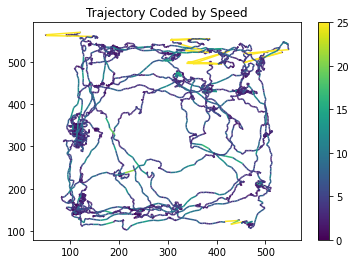

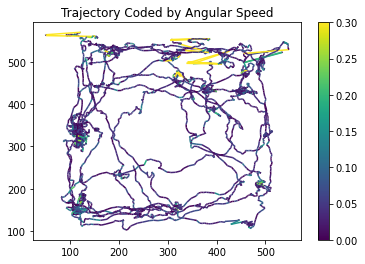

In [161]:
# color-coded trajectory plots
def plot_trajectory(color_arr):
    fig, ax = plt.subplots()
    coll = LineCollection(segments, array=color_arr, cmap="viridis")
    ax.add_collection(coll)
    ax.autoscale_view()
    fig.colorbar(coll)

body_xy = np.vstack((body_x, body_y)).T
body_xy = body_xy.reshape(-1,1,2)
segments = np.hstack((body_xy[:-1], body_xy[1:])) # (10379, 2, 2)

# set threshold to increase visualization contrast
speed[speed > 25] = 25
angular_speed[angular_speed > 0.3] = 0.3

plot_trajectory(speed)
plt.title("Trajectory Coded by Speed")
plt.show()

plot_trajectory(angular_speed)
plt.title("Trajectory Coded by Angular Speed")
plt.show()

c:\Users\Nathan\anaconda3\envs\tf_gpu\lib\site-packages\matplotlib\quiver.py:635: RuntimeWarning: Mean of empty slice.
  amean = a.mean()
c:\Users\Nathan\anaconda3\envs\tf_gpu\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: index 10378 is out of bounds for axis 0 with size 10378

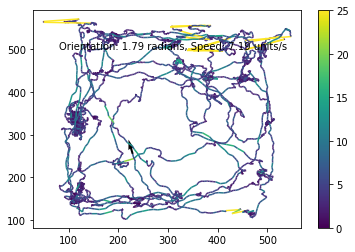

In [163]:
# --- draw blank plot ---
fig, ax = plt.subplots()

# line segments
coll = LineCollection([], array=speed, cmap="viridis")
ax.add_collection(coll)
fig.colorbar(coll)

vector = ax.quiver([],[]) # direction vector

# title with metrics
title = ax.text(80, 500, "")

# chart dimensions
padding=20
ax.set_xlim([np.amin(body_x)-padding, np.amax(body_x)+padding])
ax.set_ylim([np.amin(body_y)-padding, np.amax(body_y)+padding])
# --- end of draw blank plot ---

def generate_frame(idx, coll):
    coll.set_segments(segments[:idx]) # update segments

    # update direction vector
    global vector
    vector.remove()
    vector = ax.quiver(body_x[idx], body_y[idx], dir_x[idx], dir_y[idx])

    # update title
    title.set_text(f"Orientation: {angles[idx]:.2f} radians, Speed: {speed[idx]:.2f} units/s")

    return coll,

# saving animation
anim = animation.FuncAnimation(fig, generate_frame,
    frames = num_frames, 
    fargs = [coll],
    interval = 1,
    blit = True)

FFwriter = animation.FFMpegWriter(fps=15)
anim.save('trajectory.mp4', writer=FFwriter)